# Overturning Circulation

In the previous chapter, we examined the barotropic circulation by averaging out the vertical dimension.
This allowed us to analyze the circulation in terms of a scalar streamfunction $\psi$.

We will now do the same thing, but to remove the _zonal_ dimension (i.e. x or longitude).
This will reveal how the ocean moves mass in the latitude, depth plane.

Again assuming a rigid lid and no significant mass exchange with the atmosphere, we will integrate the continuity equation in the _zonal_ direction.
In this case, the integrals are over closed latitude circules.

\begin{align}
    \oint \frac{\partial u}{\partial x} dx +
    \oint \frac{\partial v}{\partial y} dx +
    \oint \frac{\partial w}{\partial z} dx &= 0 \\
    \frac{\partial}{\partial y} \oint v dx +
    \frac{\partial}{\partial z} \oint w dx &= 0 
\end{align}

Where the $u$ term vanishes based on the fundamental theorem of calculus.

The two transport terms now form a 2D non-divergent flow in the y-z plane.
That means we can represent them using a single streamfunction.

$$
   \oint v dx = - \frac{\partial \Psi}{\partial z} \ , \ \ 
   \oint w dx = \frac{\partial \Psi}{\partial y}
$$

We will calculate $\Psi$ from the ECCO data.

### Breaking things down by basin

One disadvantage of creating a single $\Psi$ for the global ocean is that we lose any specificity about where the transport is occuring.
One way to overcome this is to create a distinct streamfunction for each basin. This is possible if we consider the $u$ term, integrated between two longitudes $x_1$ and $x_2$ instead of around a closed latitude circle

$$
\int_{x_1}^{x_2} \frac{\partial u}{\partial x} dx
= u|_{x_1} - u_{x_2}
$$

If $x_1$ and $x_2$ are the meridional boundaries of the basin, the zonal velocity will vanish there, so that the $u$ term will still vanish completely, leaving us with a 2D non-divergent transport.

For the northern hemisphere, it's typical to compute separate streamfunctions for the Atlantic and the Indo-Pacific. The total overturning is just their sum:

$$ \Psi = \Psi_{Atl} + \Psi_{Pac} \ . $$

In [1]:
import xgcm
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import hvplot.xarray

plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
from intake import open_catalog
from xmitgcm.llcreader import faces_dataset_to_latlon

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["ECCOv4r3"].to_dask()
ds

<xarray.Dataset>
Dimensions:    (time: 288, k_l: 50, face: 13, j: 90, i: 90, k: 50, i_g: 90, j_g: 90, time_snp: 287, k_p1: 51, k_u: 50)
Coordinates: (12/37)
    Depth      (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC     (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    PHrefF     (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    ...         ...
    rA         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAz        (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Data variables: (12/36)
    ADVr_SLT   (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_SLT   (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_TH    (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_SLT   (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_TH    (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ...         ...
    basins     (face, j, i) int16 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceFWflx   (time, face, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    oceQsw     (time, face, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    oceSPtnd   (time, k, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    oceTAUX    (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceTAUY    (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>

In [3]:
from dask_gateway import Gateway
gway = Gateway()
cluster = gway.new_cluster()
cluster

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [4]:
# convert to lat-lon grid
ds = ds.set_coords(['basins'])
ds = faces_dataset_to_latlon(ds)
# trim y dimension
ds = ds.isel(j=slice(30,None), j_g=slice(30, None))

new_coords = {
    'lon_c': ds.XC[100].reset_coords(drop=True),
    'lon_g': ds.XG[100].reset_coords(drop=True),
    'lat_c': ds.YC[:, 0].reset_coords(drop=True),
    'lat_g': ds.YG[:, 0].reset_coords(drop=True)
}
ds = ds.assign_coords(new_coords)
for c in new_coords:
    ds[c].load()
    
# fix non-monotonic lat lon
ds.lon_c.data[ds.lon_c.data < ds.lon_c.data[0]] += 360
ds.lon_g.data[ds.lon_g.data < ds.lon_g.data[0]] += 360

swap_dims = {
    'i': 'lon_c', 'j': 'lat_c', 'i_g': 'lon_g', 'j_g': 'lat_g',
    'k': 'Z', 'k_l': 'Zl', 'k_u': 'Zu', 'k_p1': 'Zp1'
}

ds = ds.swap_dims(swap_dims)

attrs_to_swap = ['axis', 'c_grid_axis_shift']
for orig, new in swap_dims.items():
    for a in attrs_to_swap:
        if a in ds[orig].attrs:
            ds[new].attrs[a] = ds[orig].attrs[a]

ds

<xarray.Dataset>
Dimensions:    (face: 13, lon_c: 360, lon_g: 360, lat_c: 240, lat_g: 240, Z: 50, Zl: 50, Zp1: 51, Zu: 50, time: 288, time_snp: 287)
Coordinates: (12/42)
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    i          (lon_c) int64 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    i_g        (lon_g) int64 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    j          (lat_c) int64 30 31 32 33 34 35 36 ... 264 265 266 267 268 269
    j_g        (lat_g) int64 30 31 32 33 34 35 36 ... 264 265 266 267 268 269
    k          (Z) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...         ...
    dyG        (lat_c, lon_g) float32 dask.array<chunksize=(60, 90), meta=np.ndarray>
    dxG        (lat_g, lon_c) float32 dask.array<chunksize=(60, 90), meta=np.ndarray>
  * lon_c      (lon_c) float32 -37.5 -36.5 -35.5 -34.5 ... 319.5 320.5 321.5
  * lon_g      (lon_g) float32 -38.0 -37.0 -36.0 -35.0 ... 319.0 320.0 321.0
  * lat_c      (lat_c) float32 -81.46 -81.13 -80.8 -80.45 ... 67.16 67.34 67.47
  * lat_g      (lat_g) float32 -81.61 -81.28 -80.95 -80.61 ... 67.06 67.25 67.4
Data variables: (12/35)
    ADVr_SLT   (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    ADVr_TH    (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrE_SLT   (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrE_TH    (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrI_SLT   (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrI_TH    (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    ...         ...
    UVELMASS   (time, Z, lat_c, lon_g) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    VVELMASS   (time, Z, lat_g, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    UVELSTAR   (time, Z, lat_c, lon_g) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    VVELSTAR   (time, Z, lat_g, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    oceTAUX    (time, lat_c, lon_g) float32 dask.array<chunksize=(1, 60, 90), meta=np.ndarray>
    oceTAUY    (time, lat_g, lon_c) float32 dask.array<chunksize=(1, 60, 90), meta=np.ndarray>

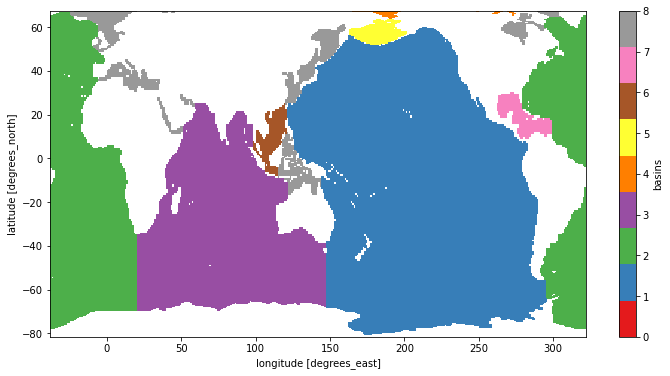

In [21]:
fig, ax = plt.subplots()
pc = ds.basins.where(ds.basins > 0).plot(cmap='Set1')
pc.set_clim([0, 8])

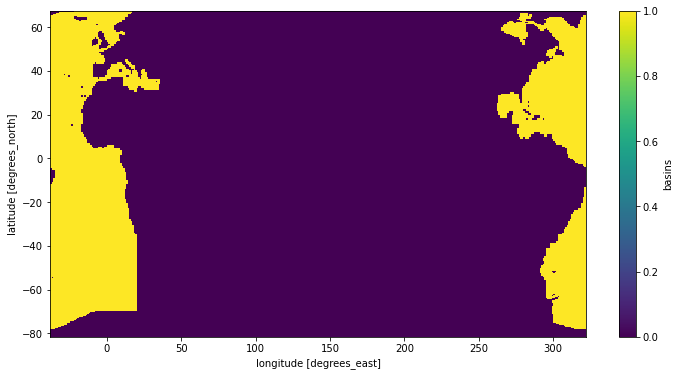

In [5]:
atl_basins = [2, 7, 9, 10, 12, 19]
atl_mask = sum([ds.basins == basin_num for basin_num in atl_basins])
atl_mask.plot()

In [8]:
grid = xgcm.Grid(ds, periodic=['X'])
grid

<xgcm.Grid>
T Axis (not periodic, boundary=None):
  * center   time --> inner
  * inner    time_snp --> center
Y Axis (not periodic, boundary=None):
  * center   lat_c --> left
  * left     lat_g --> center
X Axis (periodic, boundary=None):
  * center   lon_c --> left
  * left     lon_g --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

In [9]:
mask_v = (grid.interp(atl_mask, 'Y', boundary='fill') > 0).compute()
volume_transport = (ds.VVELMASS * ds.drF * ds.dxG)
eddy_volume_transport = (ds.VVELSTAR * ds.drF * ds.dxG)

ds_transport = xr.merge([
    volume_transport.where(mask_v).sum('lon_c').rename('V_atl'),
    volume_transport.where(~mask_v).sum('lon_c').rename('V_rest'),
    eddy_volume_transport.where(mask_v).sum('lon_c').rename('V_eddy_atl'),
    eddy_volume_transport.where(~mask_v).sum('lon_c').rename('V_eddy_rest'),
]).reset_coords(drop=True)

ds_transport

<xarray.Dataset>
Dimensions:      (lat_g: 240, Z: 50, time: 288)
Coordinates:
  * time         (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * Z            (Z) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * lat_g        (lat_g) float32 -81.61 -81.28 -80.95 ... 67.06 67.25 67.4
Data variables:
    V_atl        (time, Z, lat_g) float32 dask.array<chunksize=(1, 50, 60), meta=np.ndarray>
    V_rest       (time, Z, lat_g) float32 dask.array<chunksize=(1, 50, 60), meta=np.ndarray>
    V_eddy_atl   (time, Z, lat_g) float32 dask.array<chunksize=(1, 50, 60), meta=np.ndarray>
    V_eddy_rest  (time, Z, lat_g) float32 dask.array<chunksize=(1, 50, 60), meta=np.ndarray>

In [10]:
try:
    ds_transport = xr.open_dataset('tmp_data/ECCO_overturning_transport.nc')
except FileNotFoundError:
    import dask
    cluster.scale(10)
    with cluster.get_client():
        ds_transport.load()
        print('loaded')
    cluster.scale(0)
    ds_transport.to_netcdf('tmp_data/ECCO_overturning_transport.nc')
ds_transport

<xarray.Dataset>
Dimensions:      (time: 288, Z: 50, lat_g: 240)
Coordinates:
  * time         (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * Z            (Z) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * lat_g        (lat_g) float32 -81.61 -81.28 -80.95 ... 67.06 67.25 67.4
Data variables:
    V_atl        (time, Z, lat_g) float32 ...
    V_rest       (time, Z, lat_g) float32 ...
    V_eddy_atl   (time, Z, lat_g) float32 ...
    V_eddy_rest  (time, Z, lat_g) float32 ...

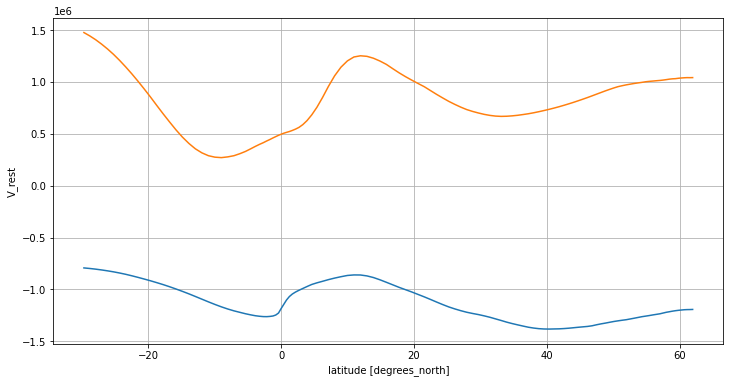

In [17]:
ds_transport.V_atl.mean('time').sum('Z').sel(lat_g=slice(-30, 62)).plot()
ds_transport.V_rest.mean('time').sum('Z').sel(lat_g=slice(-30, 62)).plot()
plt.grid()

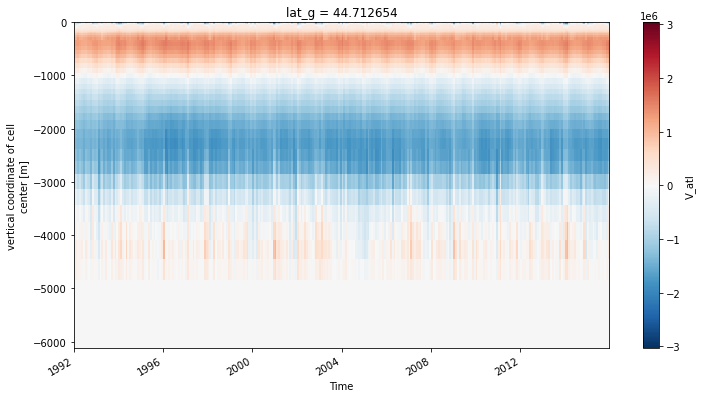

In [9]:
ds_transport.V_atl.sel(lat_g=45, method='nearest').plot(x='time')

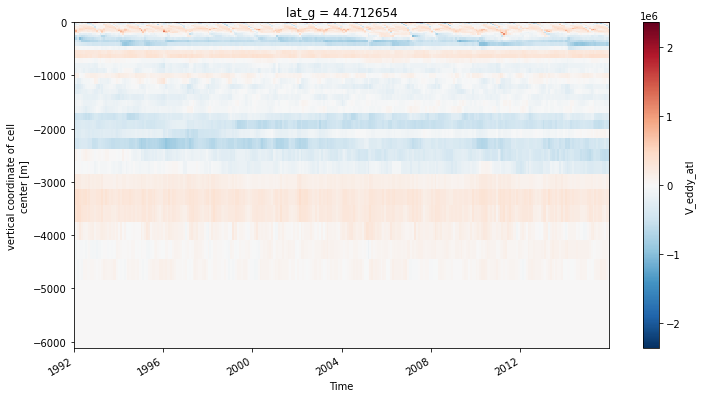

In [10]:
ds_transport.V_eddy_atl.sel(lat_g=45, method='nearest').plot(x='time')

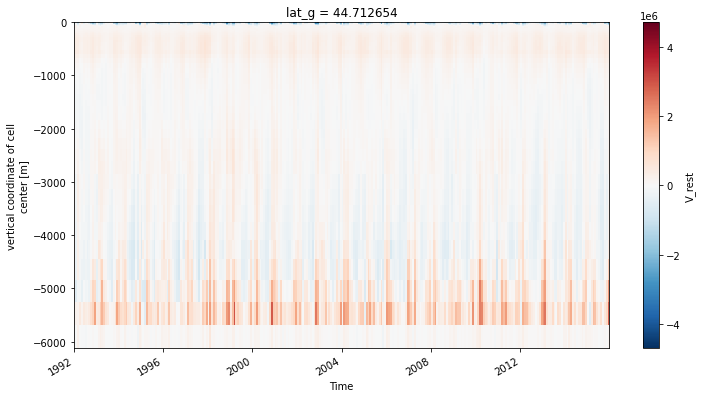

In [11]:
ds_transport.V_rest.sel(lat_g=45, method='nearest').plot(x='time')

In [12]:
def make_mean_streamfunction(V):
    return grid.cumsum(V, 'Z', boundary='fill').mean('time') / 1e6

In [13]:
streamfunctions = ds_transport.map(make_mean_streamfunction)
Psi_tot = sum(streamfunctions[v] for v in streamfunctions.data_vars)
Psi_eddy = (streamfunctions['V_eddy_atl'] + streamfunctions['V_eddy_rest'])
Psi_atl = (streamfunctions['V_atl'] + streamfunctions['V_eddy_atl']).sel(lat_g=slice(-30, None))
Psi_rest = (streamfunctions['V_rest'] + streamfunctions['V_eddy_rest']).sel(lat_g=slice(-30, None))
Psi_SO = Psi_tot.sel(lat_g=slice(None, -30))                                            

Text(0.5, 1.0, 'Global Overturning Streamfunction')

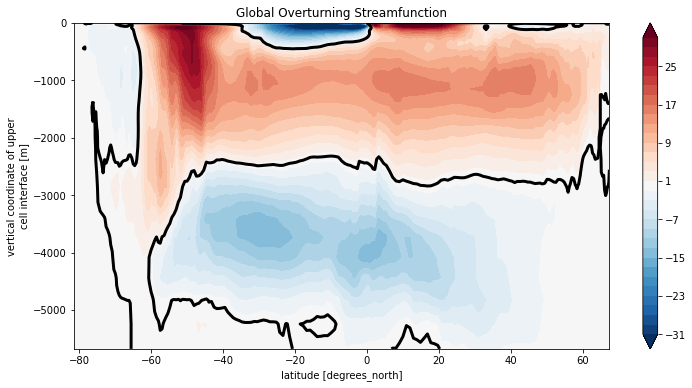

In [14]:
clevels = np.arange(-32, 32, 2) + 1
Psi_tot.plot.contourf(levels=clevels, yincrease=True)
Psi_tot.plot.contour(levels=[0], colors='k', linewidths=3)
plt.title('Global Overturning Streamfunction')

Text(0.5, 1.0, 'Eddy Overturning Streamfunction')

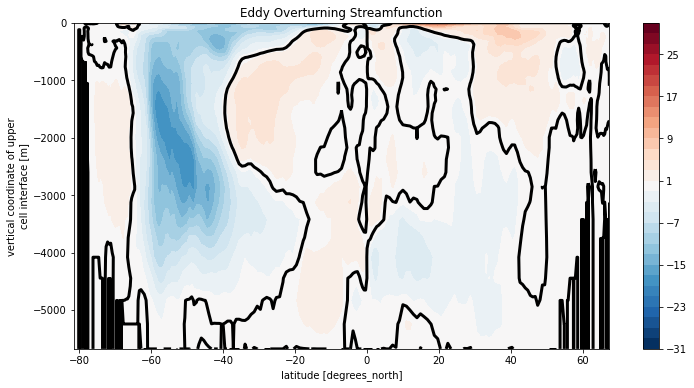

In [15]:
clevels = np.arange(-32, 32, 2) + 1
Psi_eddy.plot.contourf(levels=clevels, yincrease=True)
Psi_eddy.plot.contour(levels=[0], colors='k', linewidths=3)
plt.title('Eddy Overturning Streamfunction')

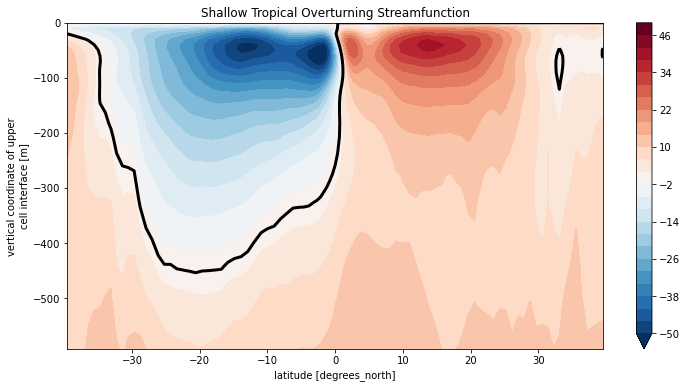

In [86]:
Psi_upper = Psi_tot.sel(lat_g=slice(-40, 40), Zl=slice(0, -600))
Psi_upper.plot.contourf(levels=np.arange(-50,52,4), yincrease=True)
Psi_upper.plot.contour(levels=[0], colors='k', linewidths=3)
plt.title('Shallow Tropical Overturning Streamfunction');

Text(0.5, 1.0, 'North Atlantic Overturning Streamfunction')

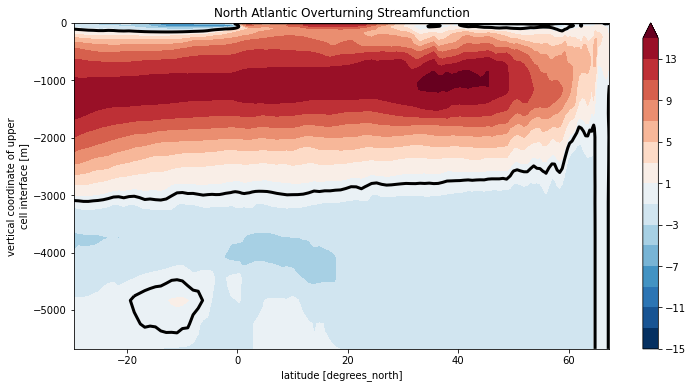

In [73]:
Psi_atl.plot.contourf(levels=np.arange(-15, 16, 2), yincrease=True)
Psi_atl.plot.contour(levels=[0], colors='k', linewidths=3)

plt.title('North Atlantic Overturning Streamfunction')

Text(0.5, 1.0, 'Indo-Pacific Overturning Streamfunction')

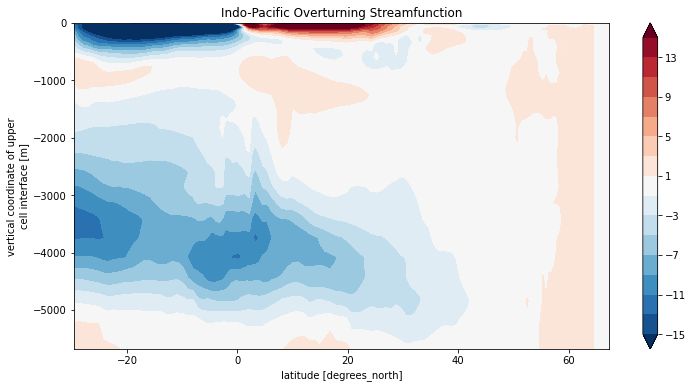

In [74]:
Psi_rest.plot.contourf(levels=np.arange(-15, 16, 2), yincrease=True)
plt.title('Indo-Pacific Overturning Streamfunction')

Text(0.5, 1.0, 'Southern Ocean Overturning Streamfunction')

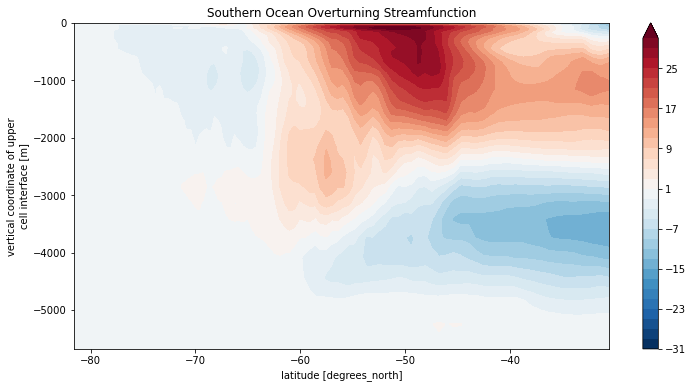

In [88]:
Psi_SO.plot.contourf(levels=clevels, yincrease=True)
plt.title('Southern Ocean Overturning Streamfunction')